# Problem 1

Implement the Perceptron algorithm to classify the dataset in “train.mat”. Plot the classification results, including the decision boundary created by the perceptron model.

## Solution

The dataset is loaded from `"train.mat"`, which contains features `x1`, `x2`, and labels `y`. The Perceptron model updates its weights based on the misclassified samples iteratively. The hypothesis function is defined as:

$$ h(\mathbf{x}) = \text{sign}(\mathbf{w}^T \mathbf{x} + b) $$

The weight update rule for misclassified samples is:

$$ \mathbf{w}_{t+1} = \mathbf{w}_t + y_i \mathbf{x}_i,\ b_{t+1} = b_t + y_i $$

where $ y_i \in \{-1, 1\} $ is the true label of the sample $ \mathbf{x}_i $.

After training, we plot the classification results along with the decision boundary: $ \mathbf{w}^T \mathbf{x} + b = 0 $.


In [12]:
pip install --no-build-isolation -Uq pip torch torchvision scipy tqdm matplotlib numpy Pillow

Note: you may need to restart the kernel to use updated packages.


{'X_train': (70, 2), 'y_train': (70,)}
Training converged after 6 epochs.
Perceptron Training Accuracy: 100.00%


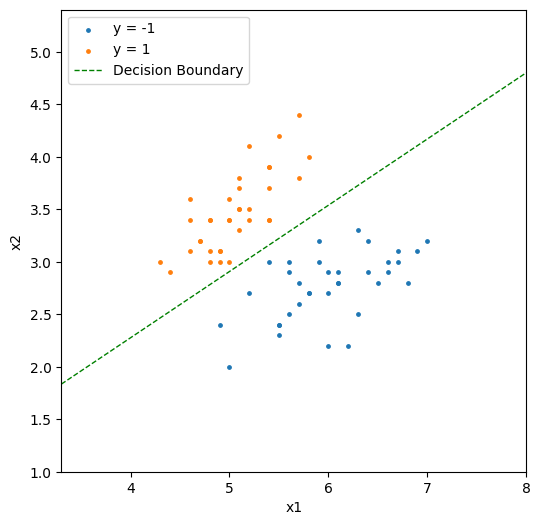

In [2]:
import torch
import scipy.io
import matplotlib.pyplot as plt
from typing import Tuple


def load_perceptron_data(file_path: str) -> Tuple[torch.Tensor, torch.Tensor]:
    data = scipy.io.loadmat(file_path)
    x1 = torch.tensor(data["x1"], dtype=torch.float32).reshape(-1, 1)
    x2 = torch.tensor(data["x2"], dtype=torch.float32).reshape(-1, 1)
    X = torch.cat((x1, x2), dim=1)
    y = torch.tensor(data["y"].flatten(), dtype=torch.float32)
    y_domain = torch.unique(y)
    assert len(y_domain) == 2, f"Expected 2 classes, but got {len(y_domain)}."
    y = torch.where(y == y_domain[0], -1.0, 1.0)
    return X, y


def plot_decision_boundary(
    X: torch.Tensor,
    y: torch.Tensor,
    w: torch.Tensor,
    b: torch.Tensor,
    figsize: Tuple[int, int] = (6, 6),
) -> None:
    X, y, w, b = X.cpu(), y.cpu(), w.cpu(), b.cpu()

    plt.figure(figsize=figsize)
    for label in y.unique():
        plt.scatter(X[y == label, 0], X[y == label, 1], 6, label=f"y = {int(label)}")
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if w[1] != 0:
        x1_vals = torch.linspace(x_min, x_max, 100, device="cpu")
        # Decision Boundary:
        # w1 * x1 + w2 * x2 + b = 0 -> x2 = -(w1 * x1 + b) / w2
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        plt.plot(
            x1_vals,
            x2_vals,
            "g--",
            linewidth=1,
            label="Decision Boundary",
        )
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


class Perceptron:
    def __init__(self, input_dim: int) -> None:
        self.w = torch.randn(input_dim, dtype=torch.float32)
        self.b = torch.randn(1, dtype=torch.float32)

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sign(torch.matmul(X, self.w) + self.b)


def train_perceptron(
    X: torch.Tensor,
    y: torch.Tensor,
    epochs: int,
    lr: float,
) -> Perceptron:
    epochs = int(epochs)
    model = Perceptron(input_dim=X.shape[1])
    for epoch in range(1, epochs + 1):
        predictions = model.predict(X)
        updates = predictions != y
        errors = updates.sum().item()
        if errors == 0:
            print(f"Training converged after {epoch} epochs.")
            break
        else:
            model.w += lr * y[updates].unsqueeze(1).mul(X[updates]).sum(dim=0)
            model.b += lr * y[updates].sum()
    else:
        print(f"Training did not converge after {epochs} epochs.")
    return model


def calculate_accuracy(model: Perceptron, X: torch.Tensor, y: torch.Tensor) -> float:
    return model.predict(X).eq(y).float().mean().item()


X_train, y_train = load_perceptron_data("train.mat")
print(dict(X_train=tuple(X_train.shape), y_train=tuple(y_train.shape)))
torch.manual_seed(17)
model = train_perceptron(X_train, y_train, epochs=1e3, lr=1e-3)
accuracy = calculate_accuracy(model, X_train, y_train)

print(f"Perceptron Training Accuracy: {accuracy:.2%}")
plot_decision_boundary(X_train, y_train, model.w, model.b)

# Problem 2

Construct and train three neural networks with 3, 10, and 50 hidden layers, respectively. Each hidden layer should contain five neurons and use the ReLU activation function. Train each network on `"train.mat"` and evaluate them on the test dataset `"test.mat"`. Report the test error (percentage of misclassified samples) for each neural network.

## Solution


In [3]:
import scipy.io
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import trange
from typing import Tuple


def load_classification_data(file_path: str) -> Tuple[torch.Tensor, torch.Tensor]:
    data = scipy.io.loadmat(file_path)
    x1 = torch.tensor(data["x1"], dtype=torch.float32).reshape(-1, 1)
    x2 = torch.tensor(data["x2"], dtype=torch.float32).reshape(-1, 1)
    X = torch.cat((x1, x2), dim=1)
    y = torch.tensor(data["y"].flatten(), dtype=torch.long)
    num_classes = y.unique().shape[0]
    assert num_classes == 2, f"Expected 2 classes, but got {num_classes}."
    return X, y


class Model(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: int,
        hidden_size: int,
        output_size: int,
        hidden_activation: nn.Module,
    ) -> None:
        input_dim = int(input_dim)
        hidden_layers = int(hidden_layers)
        hidden_size = int(hidden_size)
        output_size = int(output_size)

        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_size),
            hidden_activation(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    hidden_activation(),
                )
                for _ in range(hidden_layers - 1)
            ],
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

    def __repr__(self):
        class_name = self.__class__.__name__
        hidden_layers = len(self.net) - 4
        hidden_size = self.net[1].out_features
        return f"{class_name}(hidden_layers={hidden_layers}, hidden_size={hidden_size})"


def train_model(
    model: nn.Module,
    data: DataLoader,
    epochs: int,
    lr: float,
) -> Model:
    epochs = int(epochs)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    progress = trange(epochs, dynamic_ncols=True, desc=f"Training {model}", unit=" e")
    progress.refresh()
    for _ in progress:
        for X, y in data:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            progress.set_postfix(dict(loss=f"{loss.item():.2f}"))
    return model


@torch.no_grad()
def test_model(model: nn.Module, data: DataLoader) -> float:
    model.eval()
    error, total = 0, 0
    for X, y in data:
        error += model(X).argmax(dim=1).ne(y).sum().item()
        total += y.size(0)
    return error / total


def experiment_for_problem_3(hidden_activation: nn.Module) -> None:
    X_train, y_train = load_classification_data("train.mat")
    X_test, y_test = load_classification_data("test.mat")
    print(dict(y_train=tuple(y_train.shape), y_test=tuple(y_test.shape)))
    hidden_layers_set = [3, 10, 50]

    for hidden_layers in hidden_layers_set:
        torch.manual_seed(31)
        model = Model(
            input_dim=X_train.shape[-1],
            hidden_size=5,
            output_size=y_train.unique().shape[0],
            hidden_layers=hidden_layers,
            hidden_activation=hidden_activation,
        )
        model = train_model(
            model,
            data=[(X_train, y_train)],
            epochs=1e3,
            lr=1e-3,
        )
        error = test_model(model, [(X_test, y_test)])
        print(dict(hidden_layers=hidden_layers, test_error=f"{error:.2%}"))

In [4]:
experiment_for_problem_3(nn.ReLU)

{'y_train': (70,), 'y_test': (30,)}


Training Model(hidden_layers=3, hidden_size=5): 100%|██████████| 1000/1000 [00:01<00:00, 663.85 e/s, loss=0.32]


{'hidden_layers': 3, 'test_error': '3.33%'}


Training Model(hidden_layers=10, hidden_size=5): 100%|██████████| 1000/1000 [00:02<00:00, 495.82 e/s, loss=0.31]


{'hidden_layers': 10, 'test_error': '3.33%'}


Training Model(hidden_layers=50, hidden_size=5): 100%|██████████| 1000/1000 [00:04<00:00, 223.13 e/s, loss=0.69]


{'hidden_layers': 50, 'test_error': '50.00%'}


# Problem 3

If you replace the ReLU activation function with the Sigmoid activation function for all neurons, how does this affect the performance of the three neural networks? Report and discuss your observations for each model.

## Solution

Sigmoid activation can lead to vanishing gradient issues in deep networks, potentially affecting the test error rates as shown in the following results. Also, the more hidden layers we have, the more pronounced the vanishing gradient problem can become.

$$ \sigma(x) = \frac{1}{1 + e^{-x}},\ \text{ReLU}(x) = \max(0, x) $$

$$ \frac{d\sigma(x)}{dx} = \sigma(x)(1 - \sigma(x)) < \frac{d\text{ReLU}(x)}{dx} = 1\ \text{if}\ x > 0 $$

In [5]:
experiment_for_problem_3(nn.Sigmoid)

{'y_train': (70,), 'y_test': (30,)}


Training Model(hidden_layers=3, hidden_size=5): 100%|██████████| 1000/1000 [00:01<00:00, 708.72 e/s, loss=0.34]


{'hidden_layers': 3, 'test_error': '3.33%'}


Training Model(hidden_layers=10, hidden_size=5): 100%|██████████| 1000/1000 [00:01<00:00, 569.62 e/s, loss=0.69]


{'hidden_layers': 10, 'test_error': '50.00%'}


Training Model(hidden_layers=50, hidden_size=5): 100%|██████████| 1000/1000 [00:04<00:00, 237.75 e/s, loss=0.69]

{'hidden_layers': 50, 'test_error': '50.00%'}


# Problem 4

The MNIST dataset consists of images of handwritten digits, with a training set of 60,000 examples and a test set of 10,000 examples. The dataset can be downloaded from http://yann.lecun.com/exdb/mnist/.


## Solution

We can use `torchvision.datasets` to download and preprocess the MNIST dataset.


# Problem 4.1

Construct a neural network-based classification model for digit recognition and train it on the MNIST training set. Report the prediction accuracy on the test set.

## Solution

We build a simple neural network with two hidden layers of size $4^5 = 1024$ to classify MNIST digits. After training, we evaluate the model on the test set and report the prediction accuracy:

$$ \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = 1 - \frac{\text{Number of incorrect predictions}}{\text{Total number of predictions}} $$

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Tuple


def get_mnist_dataloaders(batch_size: int) -> Tuple[DataLoader, DataLoader]:
    from tempfile import gettempdir

    data_dir = gettempdir()
    transform = transforms.ToTensor()
    train_set = datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform
    )
    test_set = datasets.MNIST(
        root=data_dir, train=False, download=True, transform=transform
    )
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader


def experiment_for_problem_4(
    train_loader: DataLoader, test_loader: DataLoader
) -> Tuple[Model, float]:
    torch.manual_seed(41)
    x_sample: torch.Tensor = next(iter(train_loader))[0][0, 0]
    y_sample: torch.Tensor = next(iter(train_loader))[1]
    num_classes = len(y_sample.unique())
    print(
        dict(
            x_sample=tuple(x_sample.shape),
            y_sample=tuple(y_sample.shape),
            num_classes=num_classes,
        )
    )

    model = Model(
        input_dim=x_sample.numel(),
        hidden_layers=2,
        hidden_size=4**5,
        output_size=num_classes,
        hidden_activation=nn.ReLU,
    )
    model = train_model(model, train_loader, epochs=3, lr=1e-3)
    accuracy = 1 - test_model(model, test_loader)
    return model, accuracy

In [7]:
train_loader, test_loader = get_mnist_dataloaders(200)
model_clean, accuracy_clean = experiment_for_problem_4(train_loader, test_loader)
print(f"MNIST Clean Test Accuracy: {accuracy_clean:.2%}")

{'x_sample': (28, 28), 'y_sample': (200,), 'num_classes': 10}


Training Model(hidden_layers=2, hidden_size=1024): 100%|██████████| 3/3 [00:11<00:00,  3.67s/ e, loss=1.48]


MNIST Clean Test Accuracy: 96.39%


# Problem 4.2

Introduce 10% salt-and-pepper noise to the test images using the sample code below and evaluate them using the model trained on clean images from Question 4.1. Report the prediction accuracy on the noisy test set. Compare these results with those from Question 4.1 and discuss your observations. To add salt-and-pepper noise to the images, you can use the following code snippet:

```python
# See the code snippet in the solution section
```

## Solution


MNIST Noisy Test Accuracy: 74.89%
Change of Accuracy from Clean to Noisy Test: -21.50%


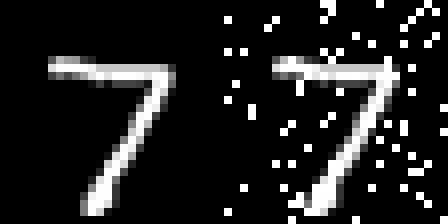

In [8]:
import torch
from torch.nn.functional import interpolate
from PIL import Image


def add_salt_noise(x: torch.Tensor, noise_level: float) -> torch.Tensor:
    x = x.clone()
    num_pixels = x.shape[-2:].numel()
    num_noisy = int(num_pixels * noise_level)
    x.view(-1).index_fill_(0, torch.randperm(num_pixels)[:num_noisy], 1.0)
    return x


def get_noisy_mnist_dataloader(
    data_loader: DataLoader,
    noise_level: float = 0.1,
) -> DataLoader:
    class NoisyDataset(torch.utils.data.Dataset):
        def __init__(self, original_dataset, noise_level):
            self.dataset = original_dataset
            self.noise_level = noise_level

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            X, y = self.dataset[idx]
            X_noisy = add_salt_noise(X.unsqueeze(0), self.noise_level).squeeze(0)
            return X_noisy, y

    noisy_dataset = NoisyDataset(data_loader.dataset, noise_level)
    noisy_loader = DataLoader(noisy_dataset, batch_size=data_loader.batch_size)
    return noisy_loader


torch.manual_seed(41)
test_loader_noisy = get_noisy_mnist_dataloader(test_loader, noise_level=0.1)
accuracy_noisy_test = 1 - test_model(model_clean, test_loader_noisy)
accuracy_diff = accuracy_noisy_test - accuracy_clean
print(f"MNIST Noisy Test Accuracy: {accuracy_noisy_test:.2%}")
print(f"Change of Accuracy from Clean to Noisy Test: {accuracy_diff:.2%}")

x_sample: torch.Tensor = next(iter(test_loader))[0][0, 0]
x_sample_noisy: torch.Tensor = next(iter(test_loader_noisy))[0][0, 0]
image_sample = torch.hstack([x_sample, x_sample_noisy]).unsqueeze(0).unsqueeze(0)
image_sample = interpolate(image_sample.mul(255).byte(), scale_factor=8).flatten(0, 2)
image_sample = Image.fromarray(image_sample.numpy())
display(image_sample)

## Discussion

Adding 10% salt noise to the test images led to a substantial drop by 21% in model performance, indicating that the model is sensitive to noise in input data.

# Problem 4.3

Add 10% salt-and-pepper noise to the training set and re-train the model on the noisy data. Then, evaluate the model on the noisy test images from Question 4.2. Report the prediction accuracy and compare these results with those from Question 4.2. Discuss any differences and insights.

## Solution


In [9]:
train_loader_noisy = get_noisy_mnist_dataloader(train_loader, noise_level=0.1)
model_noisy, accuracy_noisy_train_test = experiment_for_problem_4(
    train_loader_noisy, test_loader_noisy
)
accuracy_diff = accuracy_noisy_train_test - accuracy_noisy_test
print(f"MNIST Noisy Train-Test Accuracy: {accuracy_noisy_train_test:.2%}")
print(f"Change of Accuracy from Noisy Test to Noisy Train-Test: {accuracy_diff:.2%}")

{'x_sample': (28, 28), 'y_sample': (200,), 'num_classes': 10}


Training Model(hidden_layers=2, hidden_size=1024): 100%|██████████| 3/3 [00:14<00:00,  4.72s/ e, loss=1.50]


MNIST Noisy Train-Test Accuracy: 93.94%
Change of Accuracy from Noisy Test to Noisy Train-Test: 19.05%


In [10]:
accuracy_noisy_train_clean_test = 1 - test_model(model_noisy, test_loader)
print(f"MNIST Noisy Train Clean Test Accuracy: {accuracy_noisy_train_clean_test:.2%}")

MNIST Noisy Train Clean Test Accuracy: 95.35%


## Discussion

Training and evaluating the model on noisy dataset outperformed the model trained on clean data and tested on noisy data by 19% accuracy. This result suggests that training on noisy data can improve the model's robustness to noise in the test data.

Besides, the model trained on noisy data and tested on clean data achieved similar accuracy by 1% difference to the model trained on clean data, indicating that the model can generalize well to clean data despite being trained on noisy data.

In [11]:
%%html
<style>
    .jp-Cell.jp-Notebook-cell:last-child {
        display: none;
    }

    @page {
        size: A4 portrait;
        margin: 5mm;
    }

    @media screen {
        body {
            margin: 5mm;
        }
    }

    :root {
        --jp-content-link-color: dodgerblue;
    }

    a code {
        color: var(--jp-content-link-color) !important;
    }

    .jp-RenderedHTMLCommon {
        font-family: Calibri, Verdana, sans-serif !important;
        font-size: 13px !important;
        font-weight: 400 !important;
        line-height: 1.35 !important;
    }

    code,
    pre {
        font-family: Monaco, monospace !important;
    }

    h1 {
        text-align: center !important;
    }

    h1,
    h2,
    h3,
    h4,
    h5,
    h6,
    strong {
        font-weight: 700 !important;
    }

    h1 {
        page-break-before: always;
    }

    pre {
        white-space: pre-wrap;
    }

    table,
    td,
    th,
    tr,
    tbody,
    thead,
    tfoot {
        page-break-inside: avoid !important;
    }

    .jp-RenderedHTMLCommon td,
    .jp-RenderedHTMLCommon th,
    .jp-RenderedHTMLCommon tr {
        border: 1px solid var(--md-grey-500);
    }

    .jp-RenderedHTMLCommon table {
        margin-left: 2em;
    }

    .jp-CodeCell {
        margin-bottom: 1.5em;
    }
</style>